<a href="https://www.kaggle.com/code/krishnaprasad2608/spam-detection-awd-lstm?scriptVersionId=174806631" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1)Importing necessary libraries

In [1]:
#importing libraries
%matplotlib inline
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import fastai
from fastai import *
from fastai.text import *
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import iplot
from wordcloud import WordCloud
import re
from sklearn.utils import resample

from fastai.text.all import *

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2) Taking a glance at the data

In [2]:
df=pd.read_csv('/kaggle/input/spam-detection/spam.csv')
df

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"
...,...,...
5567,spam,"This is the 2nd time we have tried 2 contact u. U have won the £750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other suggestions?"
5570,ham,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free


In [3]:
#checking the columns
df.columns

Index(['Category', 'Message'], dtype='object')

In [4]:
#checking the null values
df.isna().sum()

Category    0
Message     0
dtype: int64

In [5]:
#converting category to numericals
df['Category'] = df['Category'].map({'spam': 1, 'ham': 0})

In [6]:
df.head(5)

,Category,Message
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


# Text preprocessing

In [7]:
# Getting the stopwords
st_wrds = stopwords.words("english")

In [8]:
# Tokenizing the data
tokenized_data = df['Message'].apply(lambda x: x.split())
tokenized_data = tokenized_data.apply(lambda x: [word for word in x if word not in st_wrds])

In [9]:
# Replacing normal text with tokenized text
tok = []
for i in range(len(df)):
    t = ' '.join(tokenized_data[i])
    tok.append(t)
df['Message'] = tok
df.sample(5)

,Category,Message
4258,1,important information 4 orange user . today lucky day!2find log onto http://www.urawinner.com THERE'S A FANTASTIC SURPRISE AWAITING YOU!
1821,0,I'll probably tomorrow (or even later tonight something's going on)
4495,0,Man bus slow. I think gonna get
923,0,It shall fine. I avalarr now. Will hollalater
2116,0,Well I available I washob nobbing last night ask Nickey Platt instead me!;


In [10]:
# Separating majority and minority classes
majority_class = df[df['Category'] == 0]
minority_class = df[df['Category'] == 1]

In [11]:
# Determining the number of samples 
oversampled_size = len(majority_class)

oversampled_size

4825

In [12]:
# Performing oversampling on the minority class 
oversampled_minority = resample(minority_class, replace=True, n_samples=oversampled_size, random_state=42)

In [13]:
# Concatenating the oversampled minority class
oversampled_df = pd.concat([majority_class, oversampled_minority])

In [14]:
# Shuffling the dataset
oversampled_df = oversampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
# Let us now split the dataset into training and validation sets
split_pcent = 0.2 
split = int(split_pcent * len(oversampled_df))

shuffled_set = oversampled_df.sample(frac=1).reset_index(drop=True)   # Shuffle the data
test_set = shuffled_set[:split]   
train_set = shuffled_set[split:] 

In [16]:
test_set.shape

(1930, 2)

# 3) DataLoaders

In [17]:
# Creating DataLoaders
dls = TextDataLoaders.from_df(train_set, text_col='Message', 
                              label_col='Category', 
                              valid_df=test_set, 
                              bs=32)

The text data from a DataFrame is handled by the DataLoader object dls,  which is initialized on the above line for training and validation purposes. Text from the 'Message' column and labels from the 'Category' column are extracted by it. With a batch size of 32 for efficient processing, the training data is stored in train_set, and the validation data is stored in  test_set.

# 4) Learner

In [18]:
# Create a text classifier learner
learn = text_classifier_learner(dls, AWD_LSTM, 
                                drop_mult=0.5,
                                metrics=[accuracy, Perplexity()])

The learn text classification learner object is initialized by the above code. It is trained with the data loader dls and the architecture AWD_LSTM. During training, the amount of dropout regularization is controlled by the drop_mult parameter. For assessing the model's performance, accuracy and perplexity are the two specified metrics. Correct classifications are measured by accuracy, and model prediction uncertainty is measured by perplexity. Better performance in text categorization challenges is indicated by lower perplexity and higher accuracy.

# 5) Finding learning rate

SuggestedLRs(minimum=0.04365158379077912, steep=0.5248074531555176, valley=0.02754228748381138, slide=0.02290867641568184)

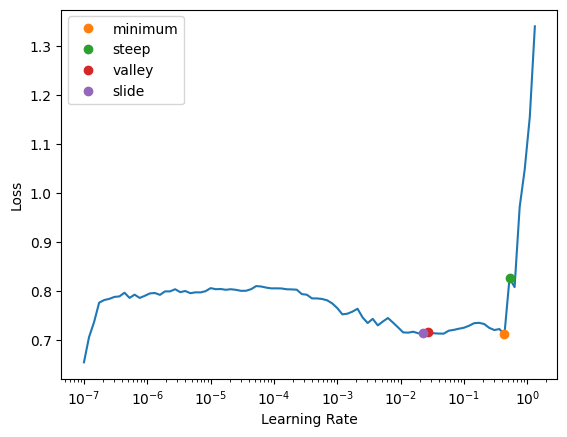

In [19]:
# Using lr_find to find suitable learning rate
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

lrs

To choose a suitable learning rate for training, the above code uses lr_find. The minimal (0.000758), steep (0.00631), valley (0.00174), and slide (0.02291) recommended learning rates are offered to help choose the best learning rate for training the model.

In [20]:
# Show a batch
learn.dls.show_batch()

,text,category
0,xxbos xxmaj how xxmaj make girl xxmaj happy ? xxmaj it 's difficult make girls happy . u need be … 1 . a friend 2 . xxmaj xxunk 3 . xxmaj lover 4 . xxmaj xxunk . . . < # > . xxmaj good xxunk < # > . xxmaj xxunk < # > . xxmaj good xxunk < # > . xxmaj very clean < # > . xxmaj xxunk < # > . xxmaj xxunk < # > . xxmaj warm . . . < # > . xxmaj xxunk < # > . xxmaj xxunk < # > . xxmaj true < # > . xxmaj xxunk < # > . xxmaj intelligent . . . < # > . xxmaj xxunk < # > . xxmaj xxunk xxunk < # > . xxmaj xxunk < # > . xxmaj xxunk . . < #,0
1,"xxbos xxmaj sad story xxmaj man - xxmaj last week b'day . xxmaj my xxmaj wife did'nt wish me . xxmaj my xxmaj parents forgot n xxmaj kids . i went work . xxmaj even xxmaj colleagues wish . xxmaj as i entered cabin xxup pa said , '' xxmaj happy xxmaj b'day xxmaj boss ! ! '' . i felt special . xxmaj she askd 4 lunch . xxmaj after lunch invited apartment . xxmaj we went there . xxmaj she said , '' u mind i go bedroom minute ? '' '' ok '' , i sed sexy mood . xxmaj she came 5 minuts latr wid cake … n xxmaj my xxmaj wife , xxmaj my xxmaj parents , xxmaj my xxmaj kidz , xxmaj my xxmaj friends n xxmaj my xxmaj colleagues . xxmaj all screaming .. xxup surprise ! ! i waiting sofa .. …",0
2,"xxbos xxmaj indians r poor xxmaj india poor country . xxmaj says one xxunk bank xxunk . xxmaj he says "" < # > xxunk xxunk "" xxmaj indian money xxunk xxunk banks used ' xxunk ' budget < # > yrs . xxmaj can give < # > xxunk xxunk xxmaj indians . xxmaj from village xxmaj xxunk 4 xxunk xxunk . xxmaj forever free power xxunk < # > social xxunk . xxmaj every citizen get monthly < # > / - < # > yrs . xxmaj no need xxmaj world xxmaj bank & & xxup xxunk loan . xxmaj think money xxunk rich xxunk . xxmaj we full xxunk xxunk xxunk . xxmaj xxunk forward xxunk xxunk xxunk xxup india xxunk . """,0
3,"xxbos a xxmaj boy loved gal . xxmaj he xxunk bt did nt mind . xxmaj he xxunk xxunk xxunk , xxmaj bt frnds xxunk thm . xxmaj again boy decided 2 xxunk gal , xxunk time xxunk xxunk towards gal . xxmaj wn 2 hit girl , d boy ran like hell n saved her . xxmaj she asked ' hw cn u run fast ? ' d boy replied "" boost secret energy "" n instantly girl shouted "" our energy "" n xxmaj xxunk xxunk xxunk xxunk drinking boost xxunk xxmaj moral xxunk i hv free msgs : d ;) : gud ni8",0
4,xxbos xxmaj for love start xxunk feel i need every time around xxunk first thing comes xxunk would start day end xxunk every time i xxunk every breath xxunk life happen around xxunk life xxunk xxunk would xxunk xxunk give happiness take xxunk ready fight anyone xxunk love i xxunk things xxunk i xxunk anyone girl beautiful lady whole xxunk always xxunk xxunk xxunk i start making xxunk xxunk end xxunk xxunk beautiful xxunk get every morning thank god day me.i would like say lot .. will tell later ..,0
5,"xxbos xxmaj storming msg : xxmaj wen u lift phne , u say "" hello "" xxmaj do u knw wt real meaning xxup hello ? ? . . . xxmaj it 's name girl .. ! . . . xxmaj yes .. xxmaj and u knw dat girl ? ? "" margaret xxmaj hello "" xxmaj she girlfrnd f xxmaj grahmbell invnted telphone … . . . . moral : one 4get name person , bt girlfrnd … g n g h . . .@",0
6,"xxbos no , * did n't * mean post it . i wrote it , like many times i 've xxunk stuff you , let sit there . xxup was feeling time . i angry . xxmaj before left , hit send , stop . xxmaj it there . i checked phone got car . xxmaj it there . xxmaj you said sleep , bored . xxmaj so xxup that time clean , xxunk xxunk , etc . ? xxmaj at least make bed ?",0
7,"xxbos xxmaj keep ur problems ur heart , xxunk nobody fight u. xxmaj only u & & u fight ur self & & win xxunk . xxunk g 9 t .. xxup xxunk .. xxunk xxmaj yeah , give call got minute xxunk xxup hi xxup babe xxup xxunk xxup xxunk xxup out xxup via xxup xxunk xxup xxunk xxup xxunk xxunk xxup xxunk  xxup xxunk , xxunk , xxunk xxup call xxup u """,0
8,"xxbos xxup hey xxup babe ! xxup far 2 xxup xxunk - out 2 xxup spk xxup at xxup da xxup mo … xxup dead 2 xxup da xxup x

# 6) Fine Tuning

In [21]:
# Fine-tune the model
learn.fine_tune(2, 
                base_lr=lrs.valley, 
                freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.577325,0.208263,0.934586,1.231537,00:05


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,0.405519,0.536176,0.963731,1.709457,00:08
1,0.177164,0.075269,0.981865,1.078174,00:08


The code uses transfer learning to fine-tune the model over two epochs. It freezes the model's parameters for the first epoch and sets the learning rate to the recommended valley value (0.00174) from the previous step. Successful model training is indicated by the following epochs, which display decreasing loss, increasing accuracy, and constant perplexity.

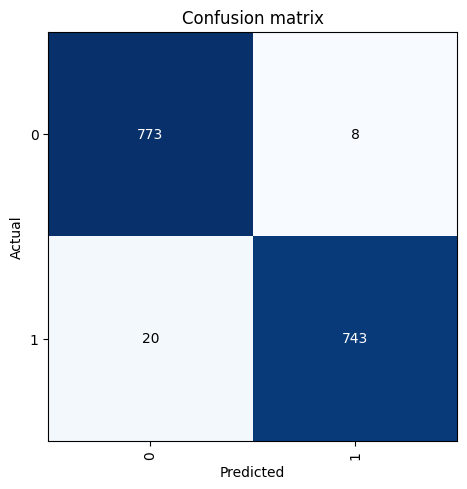

In [22]:
# Plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The confusion matrix showcases a significant number of true positives and true negatives, reflecting the model's precise classifications. Nonetheless, the occurrence of a small number of false positives and false negatives indicates instances of misclassification. False positives represent incorrect positive predictions, while false negatives denote missed positive instances. Overall, it provides insight into how well the model performs in various classes.

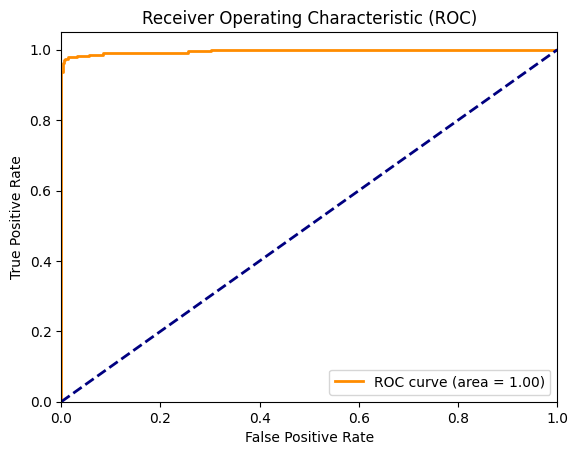

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
probs, targets = learn.get_preds()

# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(targets, probs[:,1])

# Calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Traditional NLP

In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

from sklearn.metrics import confusion_matrix


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [25]:
# Features and labels for training set
X_train = train_set['Message']
y_train = train_set['Category']

# Features and labels for test set
X_test = test_set['Message']
y_test = test_set['Category']

In [26]:
# Vectorizing text using CountVectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

The above code turns text data into numerical vectors by using CountVectorizer. It starts by setting up a CountVectorizer object. Next, it fits the vocabulary by converting the training text data (X_train) into a matrix of token counts (X_train_counts). In a similar manner, it uses the same vocabulary to convert the test text data (X_test) into token counts (X_test_counts).  This process prepares the text data for naive bayes algorithm

In [27]:
# Training a Naive Bayes classifier
NB_clf = MultinomialNB()
NB_clf.fit(X_train_counts, y_train)

MultinomialNB()

In [28]:
# Predicting on the test set
y_pred = NB_clf.predict(X_test_counts)

In [29]:
# Evaluating the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9844559585492227

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       979
           1       0.98      0.99      0.98       951

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930



The accuracy of the model is 98.45%. For each class (0 and 1), the classification report gives the F1-score, precision, and recall. Class 0 has a 98% F1-score, a 99% precision, and a 98% recall. Class 1 has a 98% F1-score, a 99% recall rate, and a 98% precision rate. High performance can be observed in both classes, based to the result.

In [30]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation
cv_scores = cross_val_score(NB_clf, X_train_counts, y_train, cv=5)  

# Print the cross-validation scores
print("Cross-validation scores:")
for i, score in enumerate(cv_scores, start=1):
    print(f" {i}: {score:.2f}")

Cross-validation scores:
 1: 0.98
 2: 0.98
 3: 0.99
 4: 0.99
 5: 0.98


The cross-validation scores show how well the model performs when the data is folded differently. Every score denotes the accuracy attained in a particular fold. Scores vary from 0.98 to 0.99, indicating great accuracy and consistency across folds, indicating the generalization and robustness of the model.

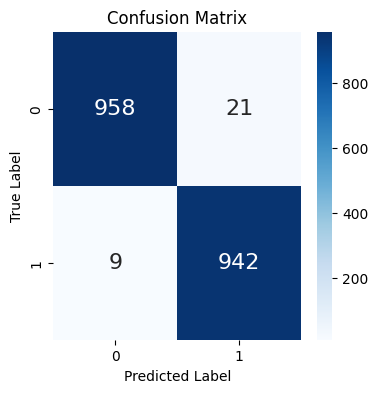

In [31]:
# Calculate confusion matrix
cm_NB = confusion_matrix(y_test, y_pred)

# Plot confusion matrix 
plt.figure(figsize=(4, 4))
sns.heatmap(cm_NB, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix displays a notable presence of true positives and true negatives, along with some instances of false positives and false negatives. This pattern indicates a generally accurate classification model.

**AWD_LSTM**

**Which model would you suggest if you had to productize this solution and why?**
A practical option for spam detection with a dataset of 6000 records is Naive Bayes. Its efficiency in training and inference matches the amount of the dataset. When it comes to text classification tasks such as spam detection, Naive Bayes works brilliantly. It uses probabilistic principles to classify messages based on word frequencies. Because of its interpretable nature, it is simple to analyze important features that affect predictions, which helps in understanding and improving the model. Furthermore, Naive Bayes uses little processing power, which means it may be implemented on a variety of platforms—including ones with limited resources. In conclusion, Naive Bayes balances effectiveness, efficiency, and interpretability for smaller datasets such as this one.

**Lessons Learnt**
AWD-LSTM shows the potential of transfer learning in spam detection, however it is interpretability-challenged and requires large computational resources. However, Naive Bayes is easy to use and effective, which makes it a good choice for smaller spam samples. 

Because of their complex design, deep learning models such as AWD-LSTM are more prone to overfitting in the domain of spam detection, where data is limited to only 6000 rows. Deep learning models require large amounts of data in order to learn efficiently, in contrast to typical machine learning algorithms, which occasionally function well with less datasets as supported by the prediction above. 

**References:**
D. (2022, April 16). Spam/ham detection using Naive bayes Classifier. Kaggle. https://www.kaggle.com/code/dilip990/spam-ham-detection-using-naive-bayes-classifier
K. (2024, March 16). Text Classification with Transfer Learning. Kaggle. https://www.kaggle.com/code/krishnaprasad2608/text-classification-with-transfer-learning
H. (2020, July 12). Twitter Sentiment CLF - EDA + Fast.ai Starter ✨. Kaggle. https://www.kaggle.com/code/heyytanay/twitter-sentiment-clf-eda-fast-ai-starter
Zola, A. (2021, December 15). spam filter. Security. https://www.techtarget.com/searchsecurity/definition/spam-filter
